# 07. DQN (N-step TD)

In [1]:
import os
from collections import deque
from typing import Deque, Dict, List, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_

## Replay buffer for N-step TD

TODO

(Please see *01.dqn.ipynb* for basic replay buffer's detailed description.)

In [2]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32, n_step: int = 3, gamma: float = 0.99):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size, self.batch_size = 0, 0, size, batch_size
        
        # for N-step TD
        self.n_step_buffer = deque(maxlen=n_step)
        self.n_step = n_step
        self.gamma = gamma

    def store(
        self, obs: np.ndarray, act: np.ndarray, rew: float, next_obs: np.ndarray, done: bool
    ) -> bool:
        transition = (obs, act, rew, next_obs, done)
        self.n_step_buffer.append(transition)

        # single step transition is not ready
        if len(self.n_step_buffer) < self.n_step:
            return False
        
        # make a n-step transition
        rew, next_obs, done = self._get_n_step_info(self.n_step_buffer, self.gamma)
        obs, action = self.n_step_buffer[0][:2]
        
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
        
        return True

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)

        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
            # for N-step TD
            indices=indices,
        )
    
    def sample_batch_from_idxs(self, idxs: np.ndarray) -> Dict[str, np.ndarray]:
        # for N-step TD
        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
        )
    
    def _get_n_step_info(
        self, n_step_buffer: Deque, gamma: float
    ) -> Tuple[np.int64, np.ndarray, bool]:
        """Return n step rew, next_obs, and done."""
        # info of the last transition
        rew, next_obs, done = n_step_buffer[-1][-3:]

        for transition in reversed(list(n_step_buffer)[:-1]):
            r, n_o, d = transition[-3:]

            rew = r + gamma * rew * (1 - d)
            next_obs, done = (n_o, d) if d else (next_obs, done)

        return rew, next_obs, done

    def __len__(self) -> int:
        return self.size

## Network

We are going to use a simple network architecture with three fully connected layers and two non-linearity functions (ReLU).

In [3]:
class Network(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        """Initialization."""
        super(Network, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_dim, 128), 
            nn.ReLU(),
            nn.Linear(128, 128), 
            nn.ReLU(), 
            nn.Linear(128, out_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        return self.layers(x)

## DQN Agent + N-step TD

TODO

In [4]:
class DQNAgent:
    """DQN Agent interacting with environment.
    
    Attribute:
        env (gym.Env): openAI Gym environment
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        epsilon (float): parameter for epsilon greedy policy
        epsilon_decay (float): step size to decrease epsilon
        max_epsilon (float): max value of epsilon
        min_epsilon (float): min value of epsilon
        target_update (int): period for target model's hard update
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        transition (list): transition information including state, action, reward, next_state, done
        use_n_step (bool): whether to use n_step memory
        n_step (int): step number to calculate n-step td error
        memory_n (ReplayBuffer): n-step replay buffer
    """

    def __init__(
        self, 
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        epsilon_decay: float,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.1,
        gamma: float = 0.99,
        # N-step TD
        n_step: int = 3,
    ):
        """Initialization.
        
        Args:
            env (gym.Env): openAI Gym environment
            memory_size (int): length of memory
            batch_size (int): batch size for sampling
            target_update (int): period for target model's hard update
            epsilon_decay (float): step size to decrease epsilon
            lr (float): learning rate
            max_epsilon (float): max value of epsilon
            min_epsilon (float): min value of epsilon
            gamma (float): discount factor
            n_step (int): step number to calculate n-step td error
        """
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        
        self.env = env
        self.batch_size = batch_size
        self.epsilon = max_epsilon
        self.epsilon_decay = epsilon_decay
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.target_update = target_update
        self.gamma = gamma
        
        # memory for 1-step TD
        self.memory = ReplayBuffer(
            obs_dim, memory_size, batch_size, n_step=1
        )
        
        # memory for N-step TD
        self.use_n_step = True if n_step > 1 else False
        if self.use_n_step:
            self.n_step = n_step
            self.memory_n = ReplayBuffer(
                obs_dim, memory_size, batch_size, n_step=n_step, gamma=gamma
            )
        
        # device: cpu / gpu
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(self.device)

        # networks: dqn, dqn_target
        self.dqn = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()
        
        # optimizer
        self.optimizer = optim.Adam(self.dqn.parameters())

        # transition to store in memory
        self.transition = list()
        
        # mode: train / test
        self.is_test = False

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # epsilon greedy policy
        if self.epsilon > np.random.random():
            selected_action = self.env.action_space.sample()
        else:
            selected_action = self.dqn(
                torch.FloatTensor(state).to(self.device)
            ).argmax()
            selected_action = selected_action.detach().cpu().numpy()
        
        if not self.is_test:
            self.transition = [state, selected_action]
        
        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, done, _ = self.env.step(action)

        if not self.is_test:
            self.transition += [reward, next_state, done]
            
            # add N-step transition
            if self.use_n_step:
                is_n_step_stored = self.memory_n.store(*self.transition)

            # add a single step transition
            if not self.use_n_step or is_n_step_stored:
                self.memory.store(*self.transition)
    
        return next_state, reward, done

    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        samples = self.memory.sample_batch()
        indices = samples["indices"]
        loss = self._compute_dqn_loss(samples, self.gamma)
        
        # N-step TD loss
        if self.use_n_step:
            samples = self.memory_n.sample_batch_from_idxs(indices)
            gamma = self.gamma ** self.n_step
            n_loss = self._compute_dqn_loss(samples, gamma)
            loss += n_loss

        self.optimizer.zero_grad()
        loss.backward()
        # gradient clipping
        # https://pytorch.org/docs/stable/nn.html#torch.nn.utils.clip_grad_norm_
        clip_grad_norm_(self.dqn.parameters(), 1.0, norm_type=1)
        self.optimizer.step()

        return loss.item()
        
    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False
        
        state = self.env.reset()
        update_cnt = 0
        epsilons = []
        losses = []
        scores = []
        score = 0

        for frame_idx in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            # if episode ends
            if done:
                state = env.reset()
                scores.append(score)
                score = 0

            # if training is ready
            if len(self.memory) >= self.batch_size:
                loss = self.update_model()
                losses.append(loss)
                update_cnt += 1
                
                # linearly decrease epsilon
                self.epsilon = max(
                    self.min_epsilon, self.epsilon - (
                        self.max_epsilon - self.min_epsilon
                    ) * self.epsilon_decay
                )
                epsilons.append(self.epsilon)
                
                # if hard update is needed
                if update_cnt % self.target_update == 0:
                    self._target_hard_update()

            # plotting
            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx, scores, losses, epsilons)
                
        self.env.close()
                
    def test(self):
        """Test the agent."""
        self.is_test = True
        
        state = self.env.reset()
        done = False
        score = 0
        
        while not done:
            self.env.render()
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()

    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray], gamma: float) -> torch.Tensor:
        """Return dqn loss."""
        state = torch.FloatTensor(samples["obs"]).to(self.device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(self.device)
        action = torch.LongTensor(samples["acts"].reshape(-1, 1)).to(self.device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(self.device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(self.device)

        # G_t   = r + gamma * v(s_{t+1})  if state != Terminal
        #       = r                       otherwise
        curr_q_value = self.dqn(state).gather(1, action)
        next_q_value = self.dqn_target(next_state).max(dim=1, keepdim=True)[0].detach()
        mask = 1 - done
        target = (reward + gamma * next_q_value * mask).to(self.device)

        # calculate dqn loss
        loss = ((target - curr_q_value).pow(2)).mean()

        return loss

    def _target_hard_update(self):
        """Hard update: target <- local."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())
                
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        losses: List[float], 
        epsilons: List[float],
    ):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses)
        plt.subplot(133)
        plt.title('epsilons')
        plt.plot(epsilons)
        plt.show()

## Environment

You can see the [code](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py) and [configurations](https://github.com/openai/gym/blob/master/gym/envs/__init__.py#L53) of CartPole-v0 from OpenAI's repository.

In [5]:
# environment
env_id = "CartPole-v0"
env = gym.make(env_id)

/home/khkim/anaconda3/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


## Set random seed

The following is how to set the random seed for reproducibility, which is guided from [pytorch documents](https://pytorch.org/docs/stable/notes/randomness.html). Unfortunately, it doesn't work properly for now (pytorch 1.0.1).

In [6]:
def seed_torch(seed=777):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    
seed_torch()

## Training

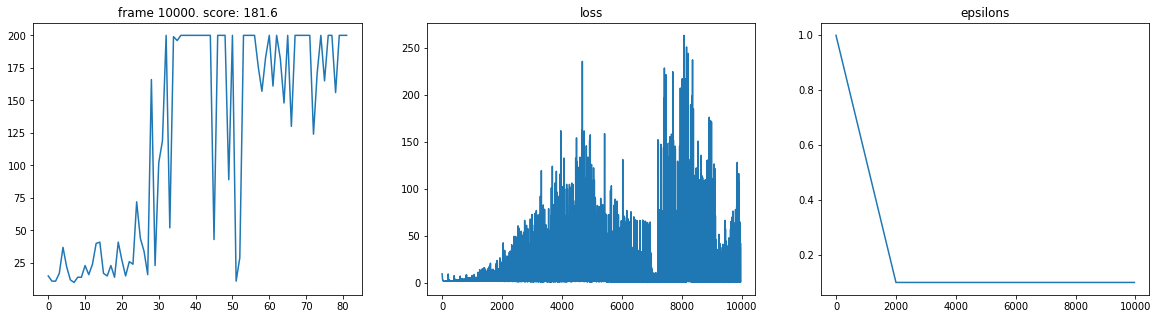

In [7]:
# parameters
num_frames = 10000
memory_size = 1000
batch_size = 32
target_update = 200
epsilon_decay = 1 / 2000

# train
agent = DQNAgent(env, memory_size, batch_size, target_update, epsilon_decay)
agent.train(num_frames)

## Test

Run the trained agent (1 episode).

In [8]:
agent.test()

score:  200.0
